# 时间序列分析建模-ARIMA类模型

时间序列建模大体上可以分为单变量建模与多变量建模。

单变量建模关注的一个单一变量$X_t$在不同时间点$t$中的变化趋势。根据研究对象的不同，可以分为对$X_t$序列的条件均值进行建模的ARIMA类模型以及对$X_t$序列的条件方差进行建模的ARCH-GARCH模型（亦称为波动率建模）。

多变量建模不仅关注某个单一序列$X_t$的变化趋势，还关注不同序列间的相互关系。代表模型有：时间序列回归模型ARMAX、向量自回归模型VAR。

本章节我们将进入对单变量建模中的经典大类模型ARIMA类模型的学习。


#  0. 大纲

在本章节，你将获得以下ARIMA建模的相关知识：
<br>
· 平稳时间序列与白噪声序列的定义、意义、判定、构造
<br>
· MA模型的定义与构造
<br>
· AR模型的定义与构造
<br>
· ARMA/ARIMA模型的定义与构造
<br>
· SARIMA模型（季节ARIMA模型）的定义与构造
<br>
· ARIMA类模型建模的全流程

## 1. 平稳时间序列

大多数统计问题都是研究如何通过大量观测样本对总体的特征与性质进行推断，但是时间序列分析却有一些不同。从随机过程的角度看，时间序列本质上一个随机过程中无数可能里的一个实现(realization)，这意味着，尽管我们也有一整列的观测数据$\{X_t\}$，但是对于每一个具体的时间点$t$而言，我们只是获得一个观测样本$(X_t)$。而时间序列分析的目标就是通过随机过程的一个具体的实现，来研究生成这个时间序列模型的概率性质。

由于时间序列在每个时间点上都只有一个观测值，因此如果我们不对其随机过程作任何限制的话，就无法通过样本对总体概率模型的性质进行有效的统计推断。这个限制正是平稳性限制，即只有时间序列满足平稳性限制，我们才能进行进一步的建模。

## 1.1 平稳过程与白噪声过程

平稳过程与白噪声过程是时间序列分析中两个最重要的概念，前者是许多时间序列模型的建模对象，后者是对时间序列建模有效性的重要度量。

### 1.1.1 两种过程的定义

**· 平稳过程**

平稳的含义，意味着时间序列的某些性质不随时间变化而改变。时间序列分析中的平稳过程，常指弱平稳过程。

若$\{X_t\}$为弱平稳过程，则时间序列$\{X_t\}$需要满足：
 
$$
· E\left(X_{t}^{2}\right)<\infty
$$
$$
· E\left(X_{t}\right)=\mu, \forall t
$$
$$
· \operatorname{Cov}\left(X_{t}, X_{t+k}\right) \text { 与t无关 }
$$

我们依次对以上条件进行解读：
<br>
1、时间序列$\{X_t\}$的方差存在。
<br>
2、时间序列$\{X_t\}$的均值是常数。这说明平稳时间序列应不存在任何趋势，若时序图存在明显的趋势，则该序列一定不平稳。
<br>
3、时间序列$\{X_t\}$的方差是常数，这是因为若第三个条件中的$k$=0时，协方差恰好就是方差$Var(X_t)$，而方差与$t$无关，这意味着方差恒为常数。这说明平稳时间序列的波动程度应当是相对恒定的，若时序图的波动性不稳定，则该序列一定不平稳。
<br>
4、时间序列$\{X_t\}$的自协方差只与时间间隔$k$有关，与时间起点$t$无关。

**· 白噪声过程**

白噪声过程也叫纯随机过程，意味着时间序列没有任何规律可循。

若$\{Z_t\}$为白噪声过程，则时间序列$\{Z_t\}$需要满足：
$$
· E\left(Z_{t}\right)=\mu, \forall t
$$
$$
· \operatorname{Var}\left(Z_{t}\right)=\sigma_{Z}^{2}, \forall t
$$
$$
· \operatorname{Cov}\left(Z_{t}, Z_{S}\right)=0, \forall t \neq s
$$

我们可以看到，白噪声过程也要求时间序列的均值与方差为常数。但与平稳过程不同的是，白噪声过程要求任意阶的自协方差都为0，这意味着白噪声过程不存在任何自相关性。

**· 自相关函数ACF与自相关ACF图**

平稳过程与白噪声过程中均值与方差的恒定性很容易就可以直接从时序图中观察出来，但是自相关性却没那么容易，这个时候我们就需要借助自相关函数ACF以及ACF图进行对时间序列自相关性的判断了。

记时间序列$\{X_t\}$的自协方差$\gamma_{X}(k)=\operatorname{Cov}\left(X_{t}, X_{t+k}\right)$，方差为$\gamma_{X}(0)$，则定义$k$阶的自相关函数ACF为：

$$
\rho(k)=\frac{\gamma_{X}(k)}{\gamma_{X}(0)}
$$

定义了自相关系数ACF后，我们就可以以延迟阶数$k$为横坐标，ACF系数$\rho(k)$为纵坐标绘制ACF图了。ACF图是时间序列分析建模的最重要工具之一，它在判断时间序列的自相关性、ARIMA模型定阶等方面将发挥重要作用，任何时序分析都应该先观察时序图以及ACF图。在这里，我们以经典的航空数据集为例，对时间序列可视化以及ACF图绘制进行Python实现。

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from IPython.display import Image
from datetime import datetime

            year  month  Number    Time
1949-01-01  1949      1     112  1949-1
1949-02-01  1949      2     118  1949-2
1949-03-01  1949      3     132  1949-3
1949-04-01  1949      4     129  1949-4
1949-05-01  1949      5     121  1949-5


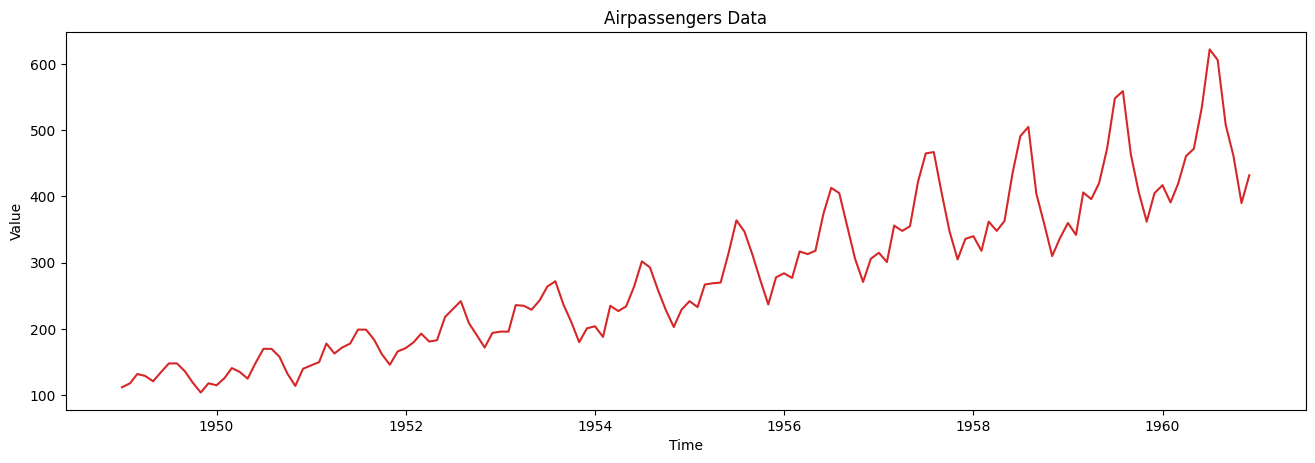

In [2]:
# 读取航空数据集
air=pd.read_csv('AirPassengers.csv')
air.index=pd.date_range(start=datetime(air.year[0],1,1),periods=len(air),freq='MS') # 设置索引为月度数据
print(air.head())

# 时间序列可视化
def plot_ts_df(df, x, y, title="", xlabel='Time', ylabel='Value', dpi=100):  # 定义时间序列可视化函数
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
plot_ts_df(air,x=air.index,y=air.Number,title='Airpassengers Data')

<bound method Figure.show of <Figure size 432x288 with 1 Axes>>

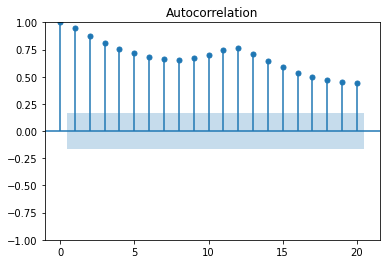

In [3]:
# 绘制acf图
plot_acf(air.Number.tolist(), lags=20,bartlett_confint=False).show

了解了自相关系数ACF的定义后，我们会自然地产生一个疑问：对于给定的延迟阶数$k$，如何通过样本自相关系数$\hat{\rho}_{k}$判断序列在该延迟阶数下的自相关程度呢？可以通过某条界限判断吗？答案是肯定的，我们将通过假设检验与置信区间解决这一问题:

若时间序列$\{X_t\}$是白噪声序列，则可以证明
$$
\hat{\rho}_{k} \approx N(0,1 / T)
$$
$T$为时间序列的长度。作假设
$$
H_{0}: \rho_{k}=0 \leftrightarrow H_{1}: \rho_{k} \neq 0
$$
根据标准正态分布的性质，求得$\hat{\rho}_{k}=0$的95%置信区间。
$$
P\left\{ \sqrt{T}\left| \hat{\rho}_k \right|\leqslant u_{0.975} \right\} =95\%\Rightarrow P\left\{ \left| \hat{\rho}_k \right|\leqslant 1.96/\sqrt{T} \right\} =95\%
$$
可以看到，样本自相关系数只要位于区间$\left[ -1.96\sqrt{T},1.96\sqrt{T} \right] $,我们就有95%的把握确定序列在该延迟项下没有自相关性，这一区间正是上面ACF图中的蓝色阴影区域。

值得注意的是，我们在使用Python statsmodels包中的plot_acf函数时，如果需要像在R语言中一样画出等宽的置信区间，一定要设置参数bartlett_confint=False，否则该函数默认画出的区间将是非等宽的。

<bound method Figure.show of <Figure size 432x288 with 1 Axes>>

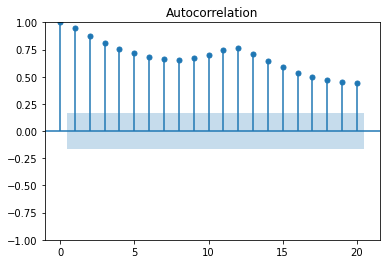

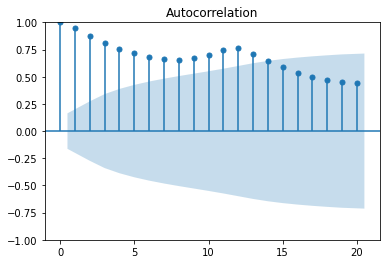

In [4]:
# 等宽置信区间
plot_acf(air.Number.tolist(), lags=20,bartlett_confint=False).show
# 非等宽置信区间
plot_acf(air.Number.tolist(), lags=20).show

### 1.1.2 两种过程的意义

**· 平稳过程的意义**

平稳性是诸多时间序列模型构建的重要前提，特别地，**Arima类模型就是在平稳时间序列的基础上建模的**。因此在正式建模前，我们必须通过ACF图或者平稳性检验对待处理时间序列的平稳性进行检测判断，如果序列不平稳，我们就需要对序列进行平稳化处理。

**· 白噪声过程的意义**

时间序列建模的本质就是挖掘时间序列中的规律信息：趋势性、季节性、平稳序列中的信息（进行Arima建模就是在挖掘平稳序列的信息）等等。如果建模充分，则真实值与预测值之间的残差序列应当不包含任何信息，即残差序列应当是白噪声序列。因此，白噪声过程是检验时间序列建模充分性的重要衡量手段，如果建模后的残差序列不是白噪声序列，则说明建模失败，需要重新建模。

### 1.1.3 平稳过程的判定

**· 先直接观察时序图**

时序图可以非常直观地呈现时间序列中一些较为明显的规律特征，如序列的趋势性、季节性、波动幅度等等。如果时序图呈现出非常明显的趋势、季节周期，或者波动幅度不稳定，那么该时间序列就一定不是平稳序列。

In [5]:
%%html
<img src='time_series.png'>

**· 再观察ACF图**

ACF图能为我们提供更多序列自相关性的细节，它不仅可以呈现时间序列的趋势性、季节性等较为明显的特征，还可以呈现难以在时序图中体现的信息。接下来，我们介绍一些较为典型的时间序列ACF图，以帮助大家日后快速判断序列的大致情况。

In [6]:
%%html
<img src='平稳序列.png'>

可以看到，白噪声序列的任意延迟阶ACF几乎都不显著，而短期自相关序列只有在前面较小的延迟阶数显著，随着延迟阶数的增加，其ACF**迅速衰减**至不显著的区域内且大致稳定在0附近，这也是平稳序列的一大特征之一。

In [7]:
%%html
<img src='趋势序列.png'>

可以看到，带有确定性趋势的序列ACF下降十分缓慢，与前面的短期自相关序列形成了较为鲜明的对比。而带有随机性趋势的序列尽管看似很快收敛至不显著区域内，但是随着延迟阶数的增加，其ACF并不收敛至0附近，因此它也不是平稳序列。

In [8]:
%%html
<img src='季节序列.png'>

带有季节性的时间序列，其ACF图也将呈现出周期性。

### 1.1.4 白噪声过程的判定

前面我们介绍了如何判定序列的平稳性，现在我们将介绍如何判定一个序列为白噪声序列。

我们可以像判断平稳过程一样观察序列的ACF图，但是这样的判断并不严格，我们希望有一种方法可以肯定地告诉大家某个序列是不是白噪声序列。现在我们将介绍一个严格的白噪声统计检验方法：Box-Pierce's混成检验。

混成检验的思想是这样的：如果一个时间序列$\{X_t\}$是白噪声序列（完全随机序列），那么它在任意延迟阶数上的ACF都应该为0，即对于**任意给定的**延迟阶数m，应当有：$\rho_{1}=\rho_{2}=\cdots=\rho_{m}=0$

因此白噪声序列检验，本质上就是进行以下假设检验：对于任意$m$，检验
$$
H_{0}: \rho_{1}=\rho_{2}=\cdots=\rho_{m}=0 \leftrightarrow H_{1}: \exists \rho_{j} \neq 0,1 \leq j \leq m
$$
由于在完全随机的假设下，$\rho_{k}有近似正态分布假设成立：
$$
\hat{\rho}_{k} \approx N\left(0, \frac{1}{T}\right)
$$
因此我们可以构造下列的检验统计量，使其近似服从卡方分布：
$$
Q_*(m)=T\sum_{k=1}^m{\underline{\rho _{k}^{2}}}\approx \chi _{m}^{2}
$$
当$Q_{*}(m)>\chi_{m}^{2}(1-\alpha)$时，就拒绝原假设，不能认为序列为白噪声序列。

我们生成一组高斯白噪声序列，并用Box—Pierce's检验去验证其白噪声性质。作为对比，我们也对AirPassangers数据集进行白噪声检验。

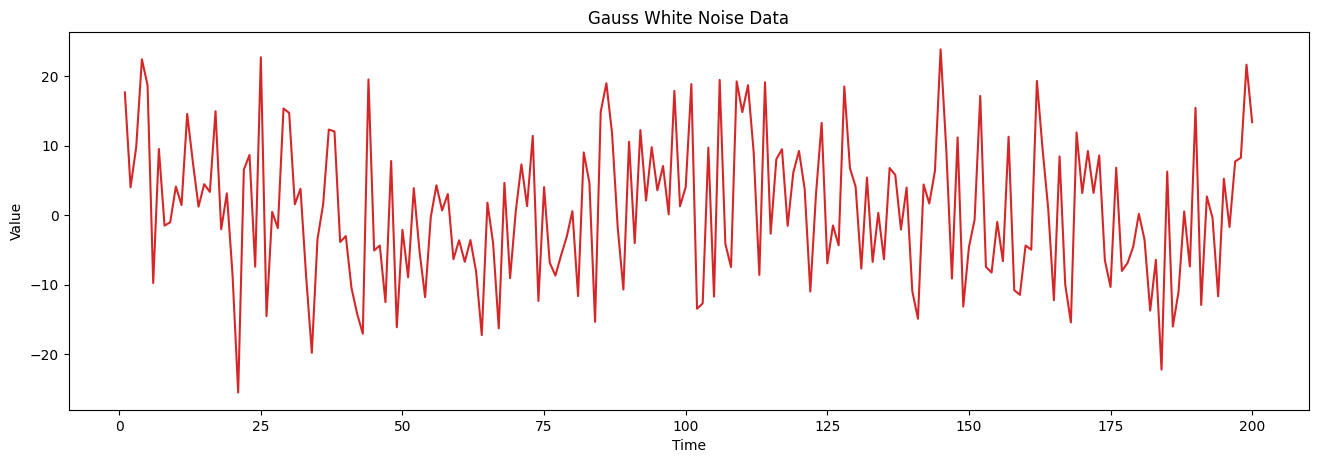

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.280292,0.596510,0.276129,0.599249
2,2.562465,0.277695,2.513111,0.284633
3,3.627464,0.304603,3.551748,0.314112
4,4.976153,0.289753,4.860378,0.301926
5,6.488966,0.261503,6.320766,0.276246


,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,132.141539,1.393231e-30,129.426301,5.471060e-30
2,245.646160,4.556318e-54,239.821208,8.384679e-53
3,342.674826,5.751088e-74,333.526974,5.499710e-72
4,427.738684,2.817731e-91,415.095056,1.522155e-88
5,504.796570,7.360195e-107,488.458387,2.473624e-103
6,575.601854,4.264008e-121,555.383929,9.752966e-117
7,643.038593,1.305463e-134,618.663609,2.327567e-129


In [9]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# 生成一组服从高斯分布的随机数
rng=np.random.RandomState(0)
y=10*rng.randn(200)
x=np.arange(1,201)
random_data={'Number':y,'Time':x}
frame=pd.DataFrame(random_data)
plot_ts_df(frame,x=frame.Time,y=frame.Number,title='Gauss White Noise Data')

# 对生成的白噪声序列进行Box—Pierce's检验
Noise_result=acorr_ljungbox(frame.Number,lags=5,boxpierce=True,model_df=0)
display(Noise_result)
# 对AirPassengers初始数据进行Box—Pierce's检验
Air_result=acorr_ljungbox(air.Number,lags=7,boxpierce=True,model_df=0)
display(Air_result)


在参数设置方面，lags指定了白噪声检验的延迟阶数，最后结果将返回从1到指定阶数中间所有阶数的检验结果，该参数可根据自己的需求设置；model_df则需要根据序列的拟合自由度设置，如果我们检验的是残差序列，则该参数需要设置为模型中参数的个数（后面会提及），而这里我们检验的是单纯的时间序列，因此默认设置为0。Box—Pierce's检验的结果将以Dataframe的形式呈现。其中，bp_stat是Box—Pierce统计量，bp-value是对应的p值。

可以看到，高斯随机序列在1-5阶延迟阶数上皆不显著，可以认为它是白噪声序列；而AirPassengers初始数据在1-7阶上都显著，可以认为它不是白噪声序列。

除了Box—Pierce's检验，还有Ljung-Box's检验可以选择。Ljung-Box's检验的检验统计量为：
$$
L B(m)=T(T+2) \sum_{k=1}^{m} \frac{\hat{\rho}_{k}^{2}}{T-k}
$$
该统计量在小样本中比上面混成检验统计量更接近卡方分布，在大样本下差别不大，因此在实际中Ljung-Box's检验更常用。LB检验的统计量与p值分别为上面的lb_stat，lb_pvalue。

## 1.2 如何获得平稳序列

我们已经较为系统地介绍了平稳过程的定义、意义与判定，接下来我们将学习如何将初始的不平稳序列处理为平稳序列。

通过对前面典型的不平稳序列的观察，我们可以知道，一般情况下导致序列不平稳的因素主要有三种：方差不稳定（波动程度越来越大）、序列存在季节性、序列存在趋势性。我们将依次介绍解决这三种问题的方法。

### 1.2.1 方差稳定化——Box Cox变换

方差不稳定大体上分为两种情况：第一种是序列波动幅度会随着均值的增大而增大，第二种则是方差变化与均值无关。对于前者，一种合适的对时间序列变量$\{X_t\}$的全局变换可以使其方差变得稳定，进而可以使用以方差恒定为前提的模型进行建模（如ARIMA）。而对于后者，我们不论怎么变换都无济于事，这个时候我们需要考虑使用一个允许方差不恒定的模型进行建模（如ARMA-GARCH模型）。在这一部分，我们将讨论前者，并向大家介绍Box—Cox变换。

Box-Cox变换的形式为：
$$
y_{t}=f\left(x_{t}, \lambda\right)= \begin{cases}\frac{x_{t}^{\lambda}-1}{\lambda}, & \lambda \neq 0 \\ \ln x_{t}, & \lambda=0\end{cases}
$$
$\lambda$为需要指定的变换参数。当$\lambda=0$时，序列将进行对数变换；当$\lambda=1/2$时，序列将进行平方根变换。一般情况下，对数变换是最常用的，在后续的方差平稳化操作中，我们将默认使用对数变换。

Box-Cox变换的功能主要有三点：

· **方差稳定化**。当方差随着均值的增大而增大，使用Box-Cox变换可以解决。

· **季节效应可加化**。当待处理序列是乘法模型：$X_{t}=T_{t} \cdot S_{t} \cdot I_{t}$时，季节效应将随趋势均值水平的增加而增加，表现为序列的季节波动性越来越大。而对这样的序列施加对数变换，可将乘法模型转变为加法模型：$\log \left( X_t \right) =\log \left( T_t \right) +\log \left( S_t \right) +\log \left( I_t \right) $,，而加法模型中季节效应不会随着趋势的变动而变化，进而达到了方差稳定化的目的

· **使分布更接近正态分布**。正态分布假设是许多模型的重要前提。

(array([ 7.,  9.,  8., 11., 16.,  8., 11., 12., 13., 17., 10.,  7.,  9.,
         4.,  2.]),
 array([ 7.90986874,  8.29416117,  8.67845361,  9.06274605,  9.44703849,
         9.83133092, 10.21562336, 10.5999158 , 10.98420824, 11.36850067,
        11.75279311, 12.13708555, 12.52137799, 12.90567043, 13.28996286,
        13.6742553 ]),
 <BarContainer object of 15 artists>)

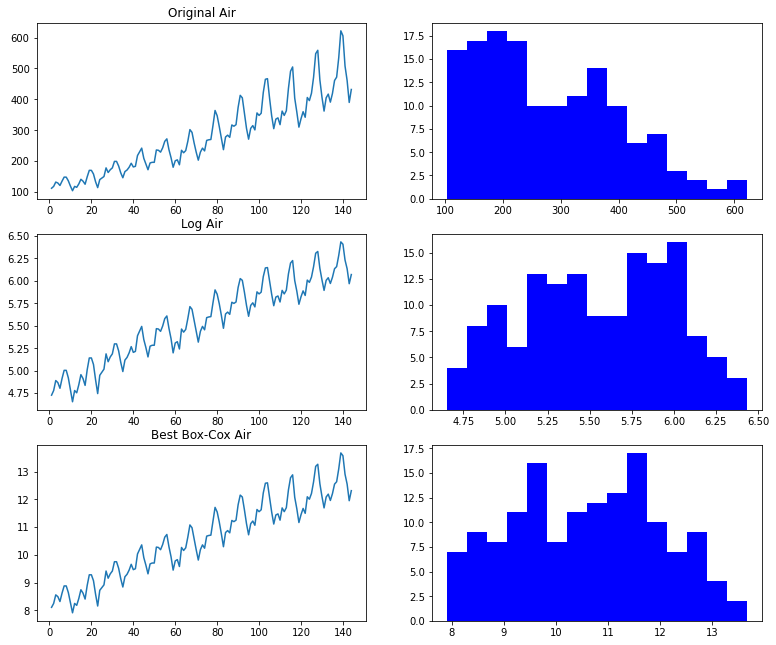

In [10]:
from scipy.special import boxcox1p # Box-Cox变换
from scipy.stats import boxcox_normmax # 返回Box-Cox变换最佳的lambda参数
import seaborn as sns
# 对AirPassengers数据进行Box-Cox对数变换
air_Number_log=boxcox1p(air.Number,0) 

# 对AirPassengers数据进行Box-Cox最佳变换
air_Number_boxcox=boxcox1p(air.Number,boxcox_normmax(air.Number)) 

# 对比变换前后的时序图与直方图
fig=plt.figure(figsize=(13,11))
ax1=fig.add_subplot(3,2,1)
ax1.plot(np.arange(1,145),air.Number)
ax1.set_title('Original Air')

ax2=fig.add_subplot(3,2,2)
ax2.hist(air.Number,bins=15,color='b')

ax3=fig.add_subplot(3,2,3)
ax3.plot(np.arange(1,145),air_Number_log)
ax3.set_title('Log Air')

ax4=fig.add_subplot(3,2,4)
ax4.hist(air_Number_log,bins=15,color='b')

ax5=fig.add_subplot(3,2,5)
ax5.plot(np.arange(1,145),air_Number_boxcox)
ax5.set_title('Best Box-Cox Air')

ax6=fig.add_subplot(3,2,6)
ax6.hist(air_Number_boxcox,bins=15,color='b')



可以看到，进行了Box-Cox变换的AirPassenger时间序列方差基本稳定了下来，且样本分布从一开始的偏态分布变成了近似正态分布，这说明我们的变换取得了不错的效果。

### 1.2.2 去除季节性与趋势性——通过确定性方法

所谓通过确定性方法去除季节性与趋势性，就是先拟合出序列的季节项与趋势项，再从原序列中减去这两项。当前较为常用的确定性分解方法分别有：经典分解法、STL分解法、X-11分解法及其变体X-13ARIMA-SEATS方法。经典分解法与STL分解法的代码实现已在第一章介绍；而X-11分解法与X-13ARIMA-SEATS方法则是一套十分复杂的方法，由于笔者能力有限，在此不做介绍；在这里，我们强调一下经典分解法与STL分解法的适用范围与特点。

**· 经典分解法**

经典分解法是最简单的序列分解方法，但局限性较大，主要有以下缺点：

1：经典分解法的趋势项是通过移动平均法获得的，因此它无法获得序列两端的趋势估计，进而无法得到两端对应的非规则项。
<br>
2：经典分解法假设序列的季节性恒定不变，这一假设在时间序列较长的情况下可能不成立。

**· STL分解法**

STL分解法解决了经典分解法中的缺点，一般情况下，STL分解法会比经典分解法更为常用。

1：STL分解法可以处理任意形式的季节性，不限于季度、月度数据。
<br>
2：STL分解法中的季节成分可随时间变化。
<br>
3：STL分解法可获得完整的趋势估计，且趋势的光滑程度可以控制。
<br>
4：STL分解法无法自动处理日历效应与交易日效应。

### 1.2.3 去除季节性与趋势性——通过差分

确定性时间序列分析的原理简单，但是一个重要的问题是会对随机性信息产生严重的浪费。而诸如ARIMA类的模型属于随机性时间序列分析法则更能挖掘隐藏在序列中的非平稳信息，因此随机性分析法更常用于对时间序列的分析。**而在对随机性分析序列的平稳化处理上，我们常用差分处理非平稳序列。**

**· 差分——差分算子与延迟算子**

差分有前向差分、向后差分、中心差分三种类型，时间序列分析中的差分为向后差分，我们现在定义$k$阶差分：
$$
Y_t=X_t-X_{t-k}=\nabla _kX_t
$$
可以看到，$k$阶差分序列$\{Y_t\}$就是序列$\{X_t\}$与它的$k$阶延迟项$\{X_{t-k}\}$之差。值得注意的是，差分序列阶数为$k$，则差分序列相较于原序列的序列长度就会减少$k$，这一点很容易就可以观察出来。

为方便后续对ARIMA模型的学习，我们引入延迟算子与差分算子对差分进行表示，后面我们将统一用这些算子表示差分。

定义延迟算子$B$，有：$B X_{t}=X_{t-1}, B^{2} X_{t}=B\left(B X_{t}\right)=X_{t-2}, \cdots$

基于延迟算子$B$，我们就可以这样表示差分算子：
$$
\nabla _kX_t=X_t-X_{t-k}=\left( 1-B^k \right) X_t
$$
最后，我们来看看python是如何实现差分的。python实现差分的函数是diff()，这是一个基于pandas.Series与pandas.Dataframe的指令，它不能对list类型的数据进行差分。


In [11]:
data={'Original_data':[3,5,2,6,9,11,20,35,38]}
df=pd.DataFrame(data)
df['diff1_data']=df.Original_data.diff(periods=1) # periods是差分阶数k
display(df)

,Original_data,diff1_data
0,3,NaN
1,5,2.0
2,2,-3.0
3,6,4.0
4,9,3.0
5,11,2.0
6,20,9.0
7,35,15.0
8,38,3.0


**· 趋势差分**

趋势差分是差分阶数为1的差分，它可以消除序列的趋势性。当我们观察到时序图呈现出明显的趋势后，可以采用趋势差分消除序列的趋势。

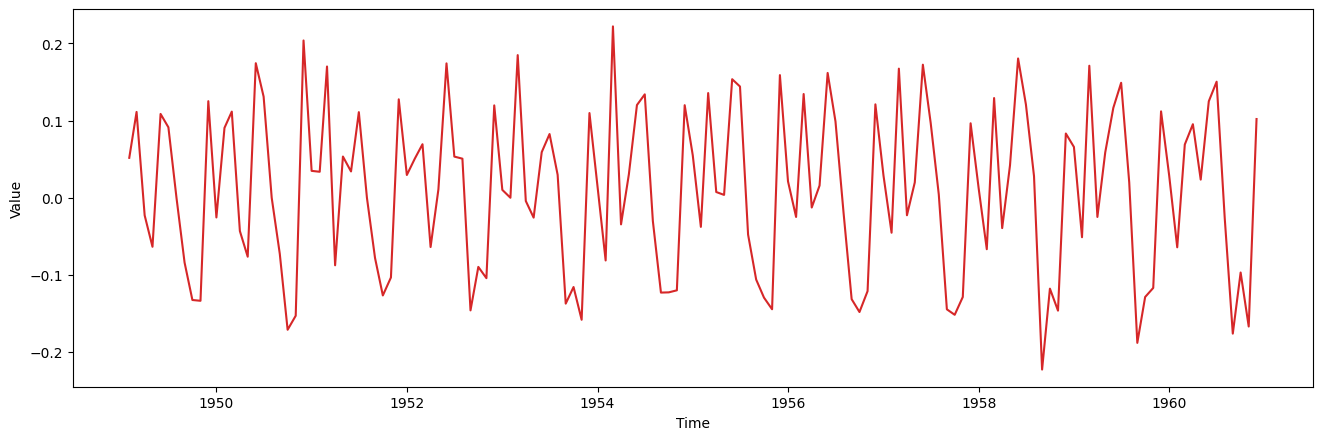

In [12]:
# 采用趋势差分消除对数化的AirPassenger的趋势
air['Number_log']=air_Number_log
air['Number_log_diff1']=air.Number_log.diff(periods=1)
plot_ts_df(air,x=air.index,y=air.Number_log_diff1)

可以看到，趋势差分后序列的趋势性已经消除。

**· 季节差分**

消除了趋势性后，若序列还存在季节性，则可以继续采用季节差分消除季节性。对于季节差分的差分阶数$k$的选定，主要是由序列的季节周期长度$s$决定的，那么$s$该如何确定呢？我们前面提到，序列的季节性在ACF图中可以反映出来，借助ACF图我们就可以较为轻松地找到周期长度$s$了。

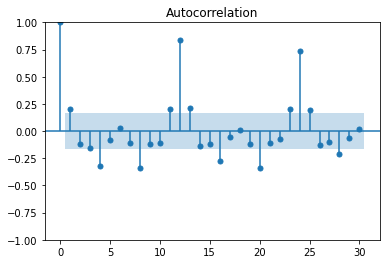

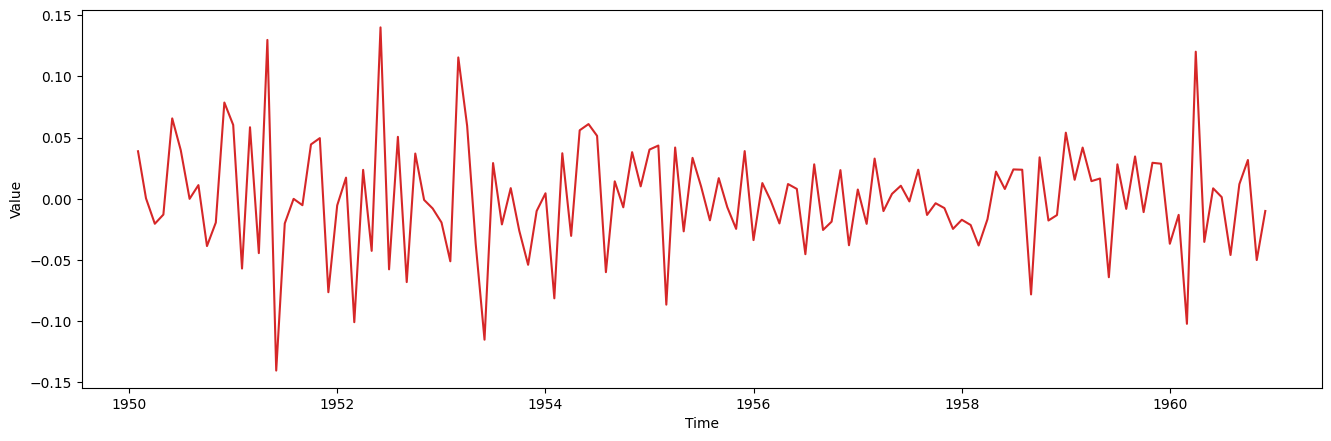

<bound method Figure.show of <Figure size 432x288 with 1 Axes>>

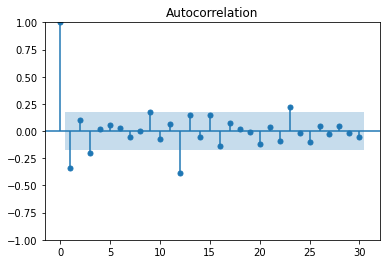

In [13]:
# 使用季节差分消除AirPassenger的季节性
plot_acf(air.Number_log_diff1.dropna().tolist(),lags=30,bartlett_confint=False).show # 注意：acf图输入的自变量不能带有NAN空值
# 注意到三条显著性水平高的时间节点间隔了12个单位间隙，可以确定s=12
air['Number_log_diff1_diff12']=air.Number_log_diff1.diff(periods=12)
plot_ts_df(air,x=air.index,y=air.Number_log_diff1_diff12)
plot_acf(air.Number_log_diff1_diff12.dropna().tolist(),lags=30,bartlett_confint=False).show


可以看到，AirPassenger序列在先后进行Box-Cox变换、趋势差分、季节差分后，其时序图与ACF图已经表现为平稳序列了。那么接下来，我们就可以正式进行ARIMA建模了。

# 2. ARIMA类模型理论储备

## 2.1 ARMA、ARIMA与SARIMA

ARIMA大类模型包含很多种，为了能让大家循序渐进地了解这些模型的区别与联系，我将以ARMA、ARIMA、SARIMA的顺序进行介绍。

ARMA(p,q)模型（Autoregressive and Moving Average model）是一类线性过程模型。所谓线性过程，就是平稳过程$\{X_t\}$与其任意阶延迟项$\left\{ X_{t\pm k} \right\} $的线性组合，因为平稳过程的线性组合依旧平稳，因此ARMA模型是针对平稳序列的模型。ARMA(p,q)模型是移动平均模型（Moving Average model,MA）和自回归模型（Autoregressive model,AR）的宏观体现，如果一个模型只含有MA(q)模型中的参数，则它是MA模型；如果一个模型只含有AR(p)模型中的参数，则它是AR模型；如果它同时含有AR与MA模型的参数，则它是ARMA模型。

介绍完ARMA模型，我们来引出ARIMA(p,d,q)模型。ARMA（包括MA、AR）是针对平稳序列的模型，但是ARIMA模型（Autoregressive Integrated Moving Average model）却是一个针对非平稳序列的模型，它是对ARMA(p,q)模型的推广，如果某个序列进行了d阶差分平稳化后服从一个ARMA(p,q)模型，则称这个序列服从ARIMA(p,d,q)模型。表面上，ARIMA建模只是相对ARMA建模多了一个差分的步骤，但由于这是针对非平稳序列的建模，要考虑的东西相对于对平稳序列进行ARMA建模要多得多——如需要额外判断序列的平稳性、判断序列是何种不平稳类型、不平稳序列是否带有截距项等等。因此，ARMA建模更像是ARIMA建模中的最后一个步骤。

最后介绍一下SARIMA模型（Seasonal Autoregressive Integrated Moving Average）。简而言之，SARIMA模型就是在季节维度上进行ARIMA建模，包括季节差分、季节维度的MA、AR模型定阶等等。之所以需要进行SARIMA建模，是因为某些序列中的特征以季节的维度出现时，直接构建ARIMA模型将过于复杂，而从季节维度上建模将大大降低模型复杂度。

在这一部分，我们先进行对各种ARIMA模型的理论与建模细节的学习：MA、AR、ARMA、SARIMA；再学习ARIMA模型建模的完整流程。

## 2.2 平稳过程中心化

### 2.2.1 中心化的意义

根据2.1的介绍我们知道了ARMA模型是一系列平稳过程$\left\{ X_{t\pm k} \right\} $的线性组合，这一系列平稳过程都有着相同的均值$\mu$。一个很朴素的疑问是：均值$\mu$的多少会影响ARMA的建模吗？如果不影响，能否假设它是0？答案是：假设均值为0不影响ARMA建模，我们称假设平稳过程均值为0的相应时间序列模型为中心化模型。接下来我们简单探讨一下中心化。

对于平稳过程$\{X_t\}$，其均值为常数$\mu$，记$Y_{t}=X_{t}-\mu$，可以看出：
$$
E\left( Y_t \right) =0 , \mathrm{Var}\left( Y_t \right) =\mathrm{Var}\left( X_t \right) \,\,, \gamma _Y(k)=\gamma _X(k)
$$
两个序列除了均值不同外，方差与自相关系数完全相同，由于ARMA模型变量参数定阶主要根据自相关系数与偏自相关系数（PACF将于后续介绍），因此这两种序列构建出来的ARMA模型结构将完全一致。那么它们区别在哪里呢？区别在于常数项。

设中心化的ARMA模型为：
$$
Y_t=\phi _1Y_{t-1}+\cdots \phi _pY_{t-p}+Z_t+\theta _1Z_{t-1}+\cdots +\theta _qZ_{t-q}
$$
非中心化的ARMA模型为：
$$
X_{t}-\mu=\phi_{1}\left(X_{t-1}-\mu\right)+\cdots \phi_{p}\left(X_{t-p}-\mu\right)+Z_{t}+\theta_{1} Z_{t-1}+\cdots+\theta_{q} Z_{t-q}
$$
展开即得：
$$
X_t=\phi _0+\phi _1X_{t-1}+\cdots \phi _pX_{t-p}+Z_t+\theta _1Z_{t-1}+\cdots +\theta _qZ_{t-q}\,\,, where\,\,\phi _0=\mu \left( 1-\phi _1-\cdots -\phi _p \right) 
$$

这说明中心化模型与非中心化模型仅仅相差在常数项$\phi _0$。因此在模型的定阶与构建的层面上，对平稳序列进行中心化是没问题的，为方便后续的理论推导，我们将统一假设平稳序列的均值为0。



### 2.2.2 中心化的注意事项

尽管中心化对ARMA模型的构建与定阶没有影响，即我们在进行ARMA建模的时候，可以很自然地将平稳序列$\{X_t\}$视作是0均值序列；但是，中心化与否会对后续的模型参数估计与预测却有影响。通过上面的公式推导，我们可以看出中心化了的ARMA模型与原ARMA模型相差了一个常数项$\phi _0$（也称为截距），忽视这个常数项会对序列的预测产生如下影响：

对不平稳序列进行ARIMA建模时，若忽略常数项，将导致模型失去对序列的时间趋势的预测能力。这是因为差分后的平稳序列$\nabla X_t$若存在均值$\mu \ne 0$，意味着$E\left( X_t-X_{t-1} \right) =\mu $，即$X_t$随着每单位时间$t$的增加，会有一个$\mu$的平均增量。如果我们在建模时忽略了常数项$\phi _0$，就意味着忽略了这一平均增量，拟合出来的模型将无法预测出序列的趋势性。

因此在实际的ARIMA建模中，如果我们可以确定原不平稳序列需要通过差分消除趋势才能平稳的话，一定要在模型设置中设置trend='c'，即模型会出现截距项。

## 2.3 MA过程

### 2.3.1 MA(q)的定义

满足下列公式的平稳过程$X_t$为（中心化的）$q$阶移动平均过程（Moving Average），记作MA(q)：
$$
X_{t}=Z_{t}+\theta_{1} Z_{t-1}+\theta_{2} Z_{t-2}+\cdots+\theta_{q} Z_{t-q}
$$
其中，$Z_t$为白噪声过程。用算子表示MA多项式：$\theta(B)=1+\theta_{1} B+\cdots+\theta_{q} B^{q}$，则MA模型可以表示为：
$$
X_{t}=\theta(B) Z_{t}
$$
可以看到，MA模型由一个当期的随机扰动项$Z_t$与一系列往期的随机扰动的线性组合构成。

注意，非中心化的MA(q)过程的公式为：
$$
X_t-\mu =Z_t+\theta _1Z_{t-1}+\cdots +\theta _qZ_{t-q}\Rightarrow X_t=\phi _0+Z_t+\theta _1Z_{t-1}+\cdots +\theta _qZ_{t-q}\text{，}where\,\,\phi _0=\mu 
$$
可以看到，**在非中心化的MA过程中，截距$\phi _0$就是均值$\mu$。**

### 2.3.2 MA(q)的ACF

**· ACF的求解**

根据ACF的公式$\rho(k)=\frac{\gamma_{X}(k)}{\gamma_{X}(0)}$，我们先求自协方差$\gamma_{X}(k)$，即$\operatorname{Cov}\left(X_{t}, X_{t+k}\right)$：

$$
\mathrm{Cov}\left( X_t,X_{t+k} \right) =E\left( X_t\cdot X_{t+k} \right) -E\left( X_t \right) E\left( X_{t+k} \right) =E\left( X_t\cdot X_{t+k} \right) 
\\
=E\left[ \left( Z_t+\theta _1Z_{t-1}+\cdots +\theta _qZ_{t-q} \right) \left( Z_{t+k}+\theta _1Z_{t+k-1}+\cdots +\theta _qZ_{t+k-q} \right) \right] 
\\
=\sum_{i=0}^{q-k}{E\left( \theta _i\theta _{i+k}Z_{t-i}Z_{t+k-i} \right)}
\\
=\sum_{i=0}^{q-k}{\theta _i\theta _{i+k}\sigma ^2}
$$
在上述推导中，我们用到了几个重要的结论：

1：中心化假设，使得$E\left( X_t \right) =E\left( X_{t+k} \right) =0$

2：白噪声序列中，不同时间点$Z_t$之间的自协方差为0，即：$Cov\left( Z_t,Z_s \right) =E\left( Z_t\cdot Z_s \right) =0$

3：白噪声序列中，只有相同时间点$Z_t$的自协方差不为0，且恰好为方差，即：$Cov\left( Z_t,Z_t \right) =Var\left( Z_t \right) =\sigma ^2$

根据上述公式推导，我们总结一下自协方差在不同延迟阶数$k$下的表达式：
$$
\gamma _k=Cov\left( X_t,X_{t+k} \right) =\begin{cases}
	\left( 1+\theta _{1}^{2}+\cdots +\theta _{q}^{2} \right) \sigma ^2\text{，}k=0\\
	\sum_{i=0}^{q-k}{\theta _i}\theta _{i+k}\sigma ^2\,\,\text{，}k\leqslant q\\
	0\text{，}k>q\\
\end{cases}
$$
进而，我们可以求出MA(q)过程的ACF：
$$
\rho _k=\frac{\gamma _k}{\gamma _0}=\begin{cases}
	\frac{\sum_{i=0}^{q-k}{\theta _i}\theta _{i+k}}{\left( 1+\theta _{1}^{2}+\cdots +\theta _{q}^{2} \right)}\text{，}k\leqslant q\\
	0\text{，}k>q\\
\end{cases}
$$
如果觉得同学们觉得公式推导较为抽象，可以参考以下图片。其实求解MA过程的ACF(k)只需要弄清楚“两个序列间哪个时间点上的随机扰动变量有重合”即可。

In [14]:
%%html
<img src='MA_ACF.png'>

**· MA过程的ACF截尾性**

上述公式表明，MA(q)过程的ACF一旦超过了$q$阶就会等于0，即有$\rho_{k}=0, \forall k>q$。后续我们会知道只有MA过程才具有ACF的截尾性，这一性质为我们在构建时间序列模型时选择MA过程，并确定MA过程的阶数提供了理论依据。在实际MA过程定阶中，如果我们看到某序列的ACF在某一阶数$k$前都大致呈现不显著，在该阶数后都大致呈现显著，则可以将此阶数$k$作为MA过程的阶数$q$。

**· 拓展：MA(q)过程的可逆性（不做要求）**

为介绍可逆性，我们先观察以下两个MA(1)模型：
$$
A: \quad X_{t}=Z_{t}+\theta Z_{t-1} \\
B: \quad X_{t}=Z_{t}+\frac{1}{\theta} Z_{t-1}
$$
由ACF公式得，这两个模型的ACF居然是完全一样的！这说明对于给定的ACF，我们可能无法识别出一个唯一的平稳MA过程与它对应，这个时候我们要引入可逆性作为模型有效性的补充。

我们设$|\theta|<1$，A与B两个模型可以进行如下变形：
$$
\begin{array}{ll}
A: & Z_{t}=X_{t}-\theta Z_{t-1}=X_{t}-\theta\left(X_{t-1}-\theta Z_{t-2}\right)=\cdots=X_{t}-\theta X_{t-1}+\theta^{2} X_{t-2}+\cdots \\
B: & Z_{t}=\theta\left(X_{t+1}-Z_{t+1}\right)=\theta X_{t+1}-\theta^{2}\left(X_{t+2}-Z_{t+2}\right)=\cdots=\theta X_{t+1}-\theta^{2} X_{t+2}+\theta^{3} X_{t+3}-\cdots
\end{array}
$$
可以看到，A模型中t时刻的随机扰动项$Z_t$可以表示为当前和过去状态值$X_t$的收敛线性组合，而B模型只能表示为未来值的线性组合。显然，未来值在实际中是不可能知道的，因此B模型不具有实际意义。

相应的，我们将可逆性进行了如下定义：若过程可逆，则$Z_t$可以表示为当前和过去状态值$X_t$的收敛和形式：
$$
Z_t=\sum_{j=0}^{\infty}{\pi _j}X_{t-j}\text{，}where\,\,\pi _0=1,\sum{\left| \pi _j \right|}<\infty 
$$
如此以来，对于给定的ACF，MA过程就可以被唯一地确认了。最后的问题是，对于MA(q)而言，它的系数$\theta _i$需要满足什么条件呢？我们不加证明的给出答案：$\theta _i$需要使得以$B$作为自变量的方程$\theta(B)=1+\theta_{1} B+\cdots+\theta_{q} B^{q}=0$的根在单位圆外，即模长大于1。（在python进行MA建模时，其求解出来的系数会自动满足这一条件，因此不必担心最后的模型不可逆）

### 2.3.3 在Python中进行MA建模

In [15]:
# 数据集使用1952-1988年中国农业实际国民收入指数序列
farm=pd.read_table('FarmingIncome.txt',names=['Year','income'])
farm.head()

,Year,income
0,1952,100.0
1,1953,101.6
2,1954,103.3
3,1955,111.5
4,1956,116.5


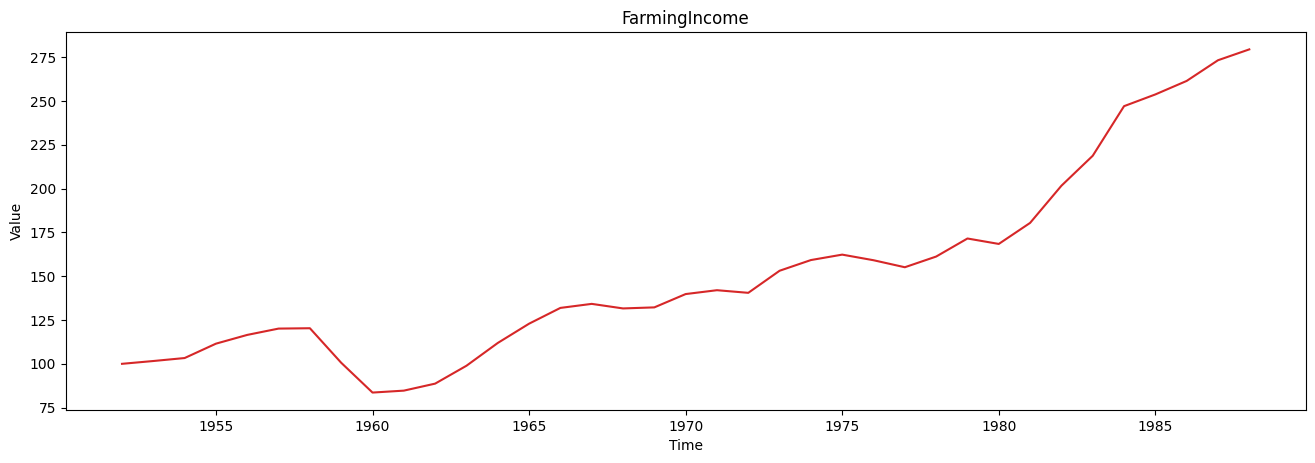

<bound method Figure.show of <Figure size 432x288 with 1 Axes>>

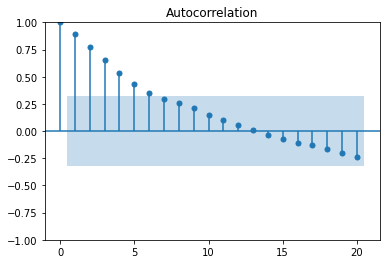

In [16]:
# 观察时序图与ACF图
plot_ts_df(farm,x=farm.Year,y=farm.income,title='FarmingIncome')
plot_acf(farm.income.tolist(),lags=20,bartlett_confint=False).show

观察时序图与ACF图知，该序列具有明显的趋势性，我们需要做趋势差分。

In [17]:
farm['income_diff1']=farm['income'].diff(periods=1)
farm[:5]

,Year,income,income_diff1
0,1952,100.0,NaN
1,1953,101.6,1.6
2,1954,103.3,1.7
3,1955,111.5,8.2
4,1956,116.5,5.0


向后一阶差分后，第一个数据会变成空值。

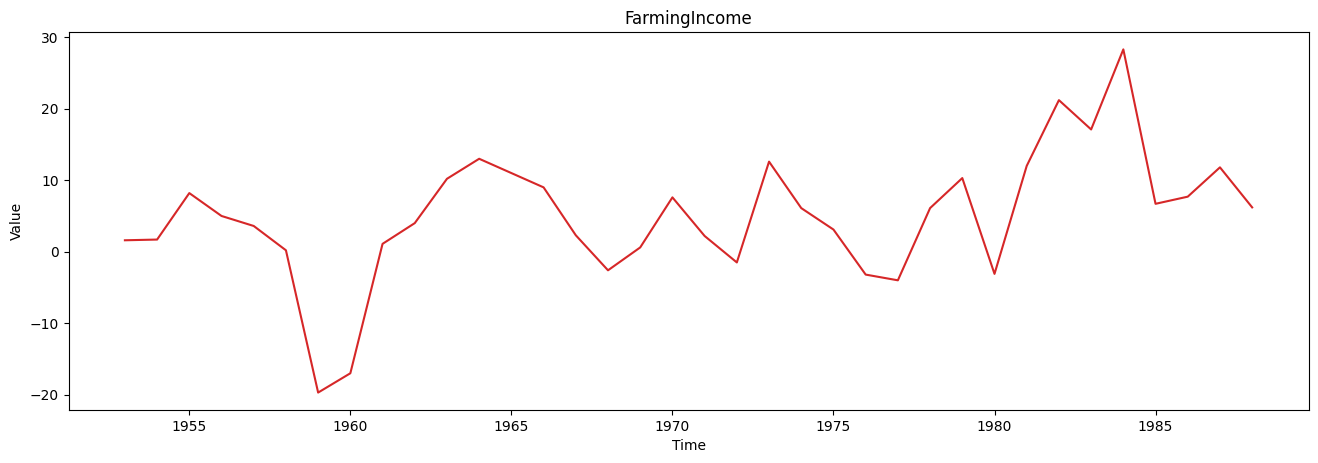

<bound method Figure.show of <Figure size 432x288 with 1 Axes>>

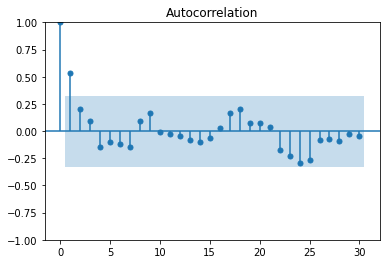

In [18]:
# 再次观察时序图与acf图
plot_ts_df(farm,x=farm.Year,y=farm.income_diff1,title='FarmingIncome')
plot_acf(farm.income_diff1.dropna().tolist(),lags=30,bartlett_confint=False).show

In [19]:
# 根据ACF图，我们可以构建MA(1)
# 我推荐大家使用statespace中的ARIMAX函数，该函数包含了Arima建模的功能，选择性更多
import statsmodels.api as sm
MA=sm.tsa.statespace.SARIMAX(farm.income,order=(0,1,1),trend='c').fit()
# order=(p,d,q)：传入Arima模型的定阶参数。我们进行了一次差分，且构建的是MA(1)模型，因此p=0,d=1,q=1
# trend='n'/'c'/'t'：模型是否加入趋势项。n为无趋势项，c为有常数截距项，t为有与时间t有关的一次函数项
print(MA.summary())

                               SARIMAX Results                                
Dep. Variable:                 income   No. Observations:                   37
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -122.987
Date:                Sat, 21 May 2022   AIC                            251.973
Time:                        20:41:42   BIC                            256.724
Sample:                             0   HQIC                           253.631
                                 - 37                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.9953      2.030      2.461      0.014       1.017       8.974
ma.L1          0.6710      0.121      5.560      0.000       0.435       0.908
sigma2        53.4135     10.747      4.970      0.0

我们在中心化的部分提到过，如果序列本身带有明显的趋势性，需要通过趋势差分进行平稳化的，一定不能忽略截距项的添加。在这里需要设置trend='c'。当然，trend在实际情况中究竟如何设置，是有一套确认流程的，我们将在后续模型构建的时候告诉大家。此外，我建议大家在传入序列的时候，要传入未经过差分处理的序列，并手动设置参数d，这样模型才会输出关于该序列的拟合值与预测值，方便大家进行后续的预测。

In [20]:
# 查看残差序列
MA_resid=MA.resid
print(MA_resid[:5])
print(len(MA_resid))

# 去除第一个数值
MA_resid.drop(0,inplace=True)
print(MA_resid[:5])
print(len(MA_resid))

0    95.004684
1    -3.398721
2    -1.722730
3     4.218909
4    -2.678188
dtype: float64
37
1   -3.398721
2   -1.722730
3    4.218909
4   -2.678188
5    0.360470
dtype: float64
36


注意：python中statsmodels包中所有可以进行Arima建模的函数（SARIMAX,Arima），若我们设置了差分选项d以及季节差分选项D不为0，它将不会拟合序列的第一个数值$X_0$（这与R不太一样），因此我们可以很明显地看到残差序列的第一个值异常的大，应当将其去除。

In [21]:
# 残差序列的白噪声检验
acorr_ljungbox(MA_resid,lags=10,model_df=1) # 注意：若检验模型的残差序列的白噪声性，应当指定自由度，MA1模型只有一个参数，因此自由度是1

,lb_stat,lb_pvalue
1,0.003905,NaN
2,0.922411,0.336843
3,1.513329,0.469229
4,3.444856,0.327985
5,3.496085,0.478474
6,3.625733,0.604454
7,4.789516,0.571079
8,5.124958,0.644717
9,6.774638,0.561131
10,7.528425,0.582276


可以看到，残差序列的1-10阶延迟项的白噪声检验都不显著，说明残差序列是白噪声序列，我们的模型是有效的。

## 2.4 AR过程

### 2.4.1 AR(p)过程的定义

满足下列公式的平稳序列$\{X_t\}$成为中心化的$p$阶自回归过程，记为AR(p):
$$
X_{t}=\phi_{1} X_{t-1}+\phi_{2} X_{t-2}+\cdots+\phi_{p} X_{t-p}+Z_{t}
$$
用算子表示AR(p)过程的多项式：$\phi(B)=1-\theta_{1} B-\cdots-\phi_{p} B^{p}$，则中心化的AR过程亦可以表示为：
$$
\phi(B) X_{t}=Z_{t}
$$
AR模型在形式上像一个多元线性回归模型，由$p$个自变量与一个当期随机扰动项$Z_t$（类似于多元回归中的误差项）构成，只不过这$p$个变量都是$X_t$自己的历史值，因此称为“自回归”。

非中心化的AR(p)过程公式为：
$$
X_{t}-\mu=\phi_{1}\left(X_{t-1}-\mu\right)+\phi_{2}\left(X_{t-2}-\mu\right)+\cdots+\phi_{p}\left(X_{t-p}-\mu\right)+Z_{t}
$$
展开即得：
$$
X_t=\phi _0+\phi _1X_{t-1}+\phi _2X_{t-2}+\cdots +\phi _pX_{t-p}+Z_t\text{，}where\,\,\phi _0=\mu \left( 1-\phi _1-\cdots -\phi _p \right) 
$$
在非中心化的AR过程中，**截距$\phi_0$不是均值$\mu$！**

### 2.4.2 AR(p)的因果平稳性条件

**· 因果性**

因果性是指当前状态值$X_t$可以表示为当前和过去时刻的随机扰动$\{Z_t\}$的**收敛**线性组合，即有MA($\infty$)的形式。可以知道，MA过程天生满足因果性。

**· 满足因果平稳性的条件**

在前面的学习中我们知道：MA(q)过程若需要满足可逆平稳性，需满足$\theta(B)=1+\theta_{1} B+\cdots+\theta_{q} B^{q}=0$的根在单位圆外。

AR(p)过程同样有类似的探讨。由于证明过程非常复杂，我们直接给出AR(p)过程因果平稳性的条件：$\phi(B)$的系数$\phi$需要使该方程的根$B$在单位圆外。

### 2.4.3 AR过程的ADF

**AR(1)与AR(p)的ADF求解**  

我们先来看看AR(1)过程的ADF(k)求解。

在模型两边同时乘$X_{t-k},k>0$，并同时做期望运算：
$$
X_t=\phi X_{t-1}+Z_t\Rightarrow X_tX_{t-k}=\phi X_{t-1}X_{t-k}+Z_tX_{t-k}\Rightarrow E\left( X_tX_{t-k} \right) =E\left( \phi X_{t-1}X_{t-k} \right) +E\left( Z_tX_{t-k} \right) 
$$
由于我们假设了$X_t$是中心化的，即均值为0，因此上述公式中的期望实际上就是自协方差：
$$
Cov\left( X_t,X_{t-k} \right) =\phi Cov\left( X_{t-1},X_{t-k} \right) +Cov\left( Z_t,X_{t-k} \right) 
$$
$Cov\left( Z_t,X_{t-k} \right)$显然是0（大家可以自己推导），因此就有公式成立：
$$
\gamma _k=\phi \gamma _{k-1}\Longrightarrow \rho _k=\phi \rho _{k-1}\Rightarrow \rho _k=\phi ^k
$$
可以看到，AR(1)过程的ACF以比率为$\phi$的指数速度衰减。我们看看当$\phi=0.8$时AR(1)的ACF图：

In [22]:
%%html
<img src='AR1_ACF.png'>

再来看看AR(p)过程的ACF(k)有怎样的特点。

我们依旧在等式两边同乘$X_{t-k}$并做期望运算：
$$
X_t=\phi _1X_{t-1}+\cdots +\phi _pX_{t-p}+Z_t\Rightarrow E\left( X_tX_{t-k} \right) =\phi _1E\left( X_{t-1}X_{t-k} \right) +\cdots +\phi _pE\left( X_{t-p}X_{t-k} \right) +E\left( Z_tX_{t-k} \right) 
$$
根据中心化过程的特点，这里的期望等价于自协方差，我们再在等式两边除以$\gamma _0$便有：
$$
\rho _k=\phi _1\rho _{k-1}+\cdots +\phi _p\rho _{k-p}\text{，}k>0
$$

**· AR过程的ACF拖尾性**

如果AR(P)满足因果平稳性，那么状态值$X_t$与$X_{t-k}$就可以展开成无限个$Z_{t-k}$的线性组合。我们从MA过程求解ACF的思想知道，ACF与两个序列展开后时间点重合的随机扰动变量$Z$个数有关，而AR过程中$X_t$可以展开成无数个随机扰动变量，这意味着$X_t$与$X_{t-k}$有无数个时间点重合的随机扰动变量，由此可见，AR过程的ACF永远不可能为0，即它不具备MA过程的acf截尾性，但具备ACF拖尾性：$\lim \rho_{k}=0, k \rightarrow \infty$

In [23]:
%%html
<img src='ar.png'>

但要注意的是，既AR过程的ACF虽然不为0，但是随着延迟阶数$k$的增大，**它会快速衰减**，这有别于非平稳过程ACF衰减缓慢的情形。

### 2.4.4 AR(p)过程的定阶——PACF

AR过程的ACF没有截尾性，意味着我们不能通过ACF对AR过程进行定阶，因此需要引进一个新的概念解决这一问题，这一新概念便是偏自相关函数(PACF)

**· PACF的定义与思想**

为了理解PACF的定义，我们先看看为什么AR模型的ACF不截尾，以AR(1)的ACF(2)为例：
$$
\gamma_{X}(2)=\operatorname{Cov}\left(X_{t}, X_{t-2}\right)=\operatorname{Cov}\left(\phi_{1} X_{t-1}+Z_{t}, X_{t-2}\right)=\operatorname{Cov}\left(\phi_{1}^{2} X_{t-2}+\phi_{1} Z_{t-1}+Z_{t}, X_{t-2}\right)=\phi_{1}^{2} \gamma_{X}(0)
$$
ACF不为0是因为$X_t$通过$X_{t-1}$而依赖于$X_{t-2}$，如果我们可以消除$X_{t-1}$的影响，就可以斩断这一链条。那么如何消除$X_{t-1}$对$X_t$与$X_{t-2}$的线性相关性影响呢？多元线性回归的知识告诉我们，分别做它们对$X_{t-1}$的回归，再减去回归的预测值，即可消除$X_{t-1}$对$X_t$与$X_{t-2}$的相关性：
$$
\widehat{X}_{t}=E\left(X_{t} \mid X_{t-1}\right)=\phi_{1} X_{t-1}  ， \widehat{X}_{t-2}=E\left(X_{t-2} \mid X_{t-1}\right)
$$
再有：
$$
\operatorname{Corr}\left(X_{t}-\widehat{X}_{t}, X_{t-2}-\widehat{X}_{t-2}\right)=\operatorname{Corr}\left(Z_{t}, X_{t-2}-\widehat{X}_{t-2}\right)=0
$$
基于此，我们这样定义$k$阶的偏自相关系数：$X_{t}$与$X_{t-k}$在消除它们之间的变量的线性效应后的相关系数Corr，便是PACF(k)，数学表达如下：
$$
\rho_{X_{t}, X_{t-k} \mid X_{t-1}, \cdots, X_{t-k+1}}=\operatorname{Corr}\left(X_{t}, X_{t-k} \mid X_{t-1}, \cdots, X_{t-K+1}\right)=\operatorname{Corr}\left(X_{t}-\widehat{X}_{t}, X_{t-k}-\widehat{X}_{t-k}\right)
$$
其中：
$$
\widehat{X}_{t}=E\left(X_{t} \mid X_{t-1}, \cdots, X_{t-k+1}\right), \widehat{X}_{t-k}=E\left(X_{t-k} \mid X_{t-1}, \cdots, X_{t-k+1}\right)
$$

**· AR(p)的PACF截尾性与MA(q)的PACF拖尾性**

AR(p)模型具有PACF截尾性：
$$
\rho_{X_{t}, X_{t-k} \mid X_{t-1}, \cdots, X_{t-k+1}} \equiv 0, \forall k>p
$$
可以很通俗地理解这一性质：当我们固定的变量数$k$超过了AR模型中$X_t$可展开的变量数$q$，$X_t$与$X_{t-k}$之间的相关性链条就被完全斩断了。

而MA(q)模型具有PACF拖尾性，这是因为一个可逆平稳的MA过程可以表示成AR($\infty$).

### 2.4.5 在Python中进行MA建模

In [24]:
# 使用德国工人失业率数据集
worker=pd.read_table('example5.9.txt',header=None).T
worker # 注意：该原始数据只有value值没有时间值，且将以下数据按列合并在一起

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.1,1.3,0.9,2.7,1.1,1.5,2.6,5.7,5.2,4.2,8.0,10.0,10.2,9.8,8.1
1,0.5,0.6,0.5,1.3,0.5,1.0,2.1,4.3,4.1,3.4,7.0,8.7,8.6,8.6,7.1
2,0.4,0.5,0.5,0.9,0.5,0.9,2.3,4.0,3.9,3.6,7.4,8.8,8.4,8.4,6.9
3,0.7,0.7,1.1,1.0,0.6,1.1,3.6,4.4,4.1,4.3,8.5,8.9,8.4,8.2,6.6
4,1.6,1.2,2.9,1.6,1.2,1.5,5.0,5.2,4.8,5.5,10.1,10.4,9.9,8.8,6.8
5,0.6,0.5,2.1,0.6,0.7,1.0,4.5,4.3,3.5,4.8,8.9,8.9,8.5,7.6,6.0
6,0.5,0.4,1.7,0.5,0.7,1.0,4.5,4.2,3.4,5.4,8.8,8.9,8.6,7.5,6.2
7,0.7,0.6,2.0,0.7,1.0,1.6,4.9,4.5,3.5,6.5,9.0,9.0,8.7,7.6,6.2


In [25]:
# 将数据整合成可供分析的Dataframe
wk=pd.Series({})
for i in np.arange(0,15):
    wk=pd.concat([wk,worker[i]],axis=0)
wk=wk.reset_index(drop=True)
wk_df=pd.DataFrame(wk,columns=['value'])
wk_df=pd.concat([wk_df,pd.DataFrame({'Time':np.arange(0,120).tolist()})],axis=1)
wk_df.head()

C:\Users\TOPSHI~1\AppData\Local\Temp/ipykernel_8348/3318498955.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wk=pd.Series({})


,value,Time
0,1.1,0
1,0.5,1
2,0.4,2
3,0.7,3
4,1.6,4


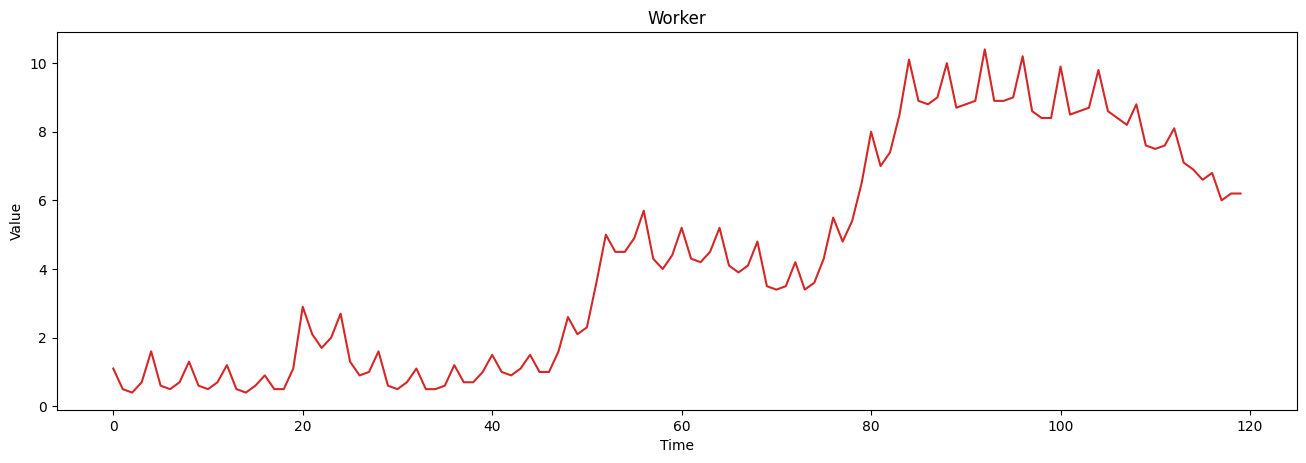

<bound method Figure.show of <Figure size 432x288 with 1 Axes>>

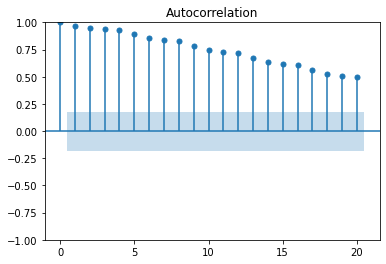

In [26]:
# 平稳性分析：查看序列的时序图，acf图
plot_ts_df(wk_df,x=wk_df.Time,y=wk_df.value,title='Worker')
plot_acf(wk_df.value.tolist(),lags=20,bartlett_confint=False).show


ACF图显示序列acf衰减缓慢，有明显的随机趋势，需要进行差分消除趋势

<bound method Figure.show of <Figure size 432x288 with 1 Axes>>

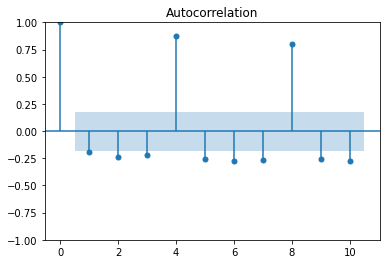

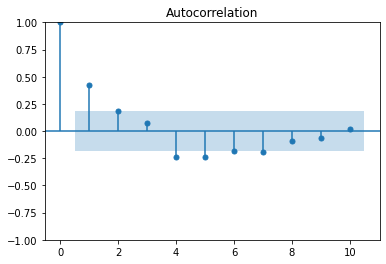

In [27]:
wk_df['value_diff1']=wk_df['value'].diff(periods=1)
# 再查看acf图
plot_acf(wk_df.value_diff1.dropna().tolist(),lags=10,bartlett_confint=False).show

# 明显带有周期为4的季节性，再进行季节差分
wk_df['value_diff1_4']=wk_df['value_diff1'].diff(periods=4)
plot_acf(wk_df.value_diff1_4.dropna().tolist(),lags=10,bartlett_confint=False).show

进行了两次差分后的序列ACF呈现出平稳的特点。可以注意到，该序列的acf的延迟阶数直到7阶仍然呈现出自相关显著性，如果选用MA(7)进行建模，模型复杂性将很高。这个时候我们可以观察PACF图。

<bound method Figure.show of <Figure size 432x288 with 1 Axes>>

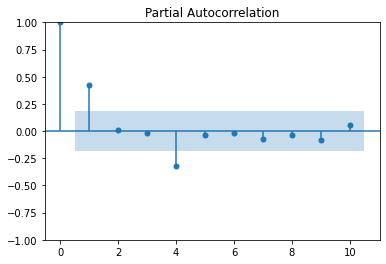

In [28]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(wk_df.value_diff1_4.dropna(),lags=10,method='ywm').show

显然，该序列的pacf在延迟阶数为4时截尾，我们可以尝试建模AR(4)

In [29]:
AR4=sm.tsa.statespace.SARIMAX(wk_df.value,order=(4,1,0),seasonal_order=(0,1,0,4),trend='c').fit()
print(AR4.summary())
print(AR4.predict())

                                     SARIMAX Results                                     
Dep. Variable:                             value   No. Observations:                  120
Model:             SARIMAX(4, 1, 0)x(0, 1, 0, 4)   Log Likelihood                 -25.491
Date:                           Sat, 21 May 2022   AIC                             62.982
Time:                                   20:41:44   BIC                             79.451
Sample:                                        0   HQIC                            69.667
                                           - 120                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0053      0.031     -0.171      0.865      -0.066       0.056
ar.L1          0.4142      0.065      6.417

查看拟合值后，我们发现模型拟合的第一个值依然异常于其他拟合值，这是因为我们进行了差分。在后续的白噪声检验中，我们需要去掉残差值的第一个。

In [30]:
AR4_resid=AR4.resid
AR4_resid.drop(0,inplace=True)
acorr_ljungbox(AR4_resid,lags=10,model_df=4)# AR4有4个参数，故指定自由度为4

,lb_stat,lb_pvalue
1,0.029123,NaN
2,0.104399,NaN
3,0.201454,NaN
4,0.209014,NaN
5,0.700407,0.402647
6,0.807979,0.667651
7,1.091745,0.779067
8,2.646210,0.618659
9,3.291534,0.655138
10,3.588897,0.732107


白噪声检验显示我们的模型是完备的。

## 2.5 ARMA过程

### 2.5.1 ARMA(p,q)的定义

满足下列公式的中心化平稳过程$X_t$成为自回归移动平均过程ARMA(p,q)：
$$
X_{t}=\phi_{1} X_{t-1}+\cdots+\phi_{p} X_{t-p}+Z_{t}+\theta_{1} Z_{t-1}+\cdots+\theta_{q} Z_{t-q}
$$
算子表示为：
$$
\phi(B) X_{t}=\theta(B) Z_{t}
$$
非中心化的ARMA(p,q)可以表示为：
$$
X_t=\phi _0+\phi _1X_{t-1}+\cdots +\phi _pX_{t-p}+Z_t+\theta _1Z_{t-1}+\cdots +\theta _qZ_{t-q}\text{，}where\,\,\phi _0=\mu \left( 1-\phi _1-\cdots -\phi _p \right) 
$$
算子表示为：
$$
\phi(B)\left(X_{t}-\mu\right)=\theta(B) Z_{t}
$$

### 2.5.2 ARMA过程的理解与意义

通过对上面ARMA模型公式的观察，我们可以知道：ARMA模型就是AR和MA模型的组合，它同时包含两个模型的参数。那么这么做的意义是什么呢——简化模型估计。

在有些较为复杂的平稳时间序列当中，它们的ACF与PACF可能都迟迟未能截尾，这将迫使我们使用高阶的AR与MA模型才能充分描述序列的动态相依结构，从而要估计大量模型参数，大大增加模型的复杂度进而造成过拟合。为克服这一困难，有人提出ARMA模型将两种模型参数结合在一起，使用少量参数就可以刻画复杂的相依结构，达到简化模型的目的。

### 2.5.3 ARMA过程的性质

**· 双拖尾性**

ARMA过程的ACF与PACF都呈现出拖尾特性，这意味着我们无法通过观察ACF与PACF图进行对ARMA(p,q)进行定阶。举个例子，假如某序列的分别在ACF(7)与PACF(8)处截尾，那么我们可能可以以此为依据构建MA(7)与AR(8)，而不能构建ARMA(8,7)。

**· 因果可逆性**

MA过程天然具有因果平稳性，AR过程天然具有可逆性，而ARMA过程如果需要具备因果平稳性与可逆性，需要分别满足$\phi(B)=0$的根在单位圆外与$\theta(B)=0$的根在单位圆外。

### 2.5.4 ARMA过程的定阶

**· EACF定阶——一种可供参考的依据**

由于python中的statsmodels包中不包含测量序列EACF的函数，在这里不做介绍，感兴趣的同学可以使用R语言内forecast包中的eacf函数，它能给大家提供一些可供选择的ARMA阶数。

**· 多模型比较——更常用的“定阶”方法**

ARMA模型更像是AR模型或者MA模型的“备选方案”，当平稳序列的ACF与PACF过于复杂时，我们才考虑使用ARMA模型。一般地，我们可以先看看ARMA(1,1)模型的效果，如果模型充分的话，我们便可以选择ARMA(1,1)，这是因为这个模型参数不多，复杂度很低。如果复杂的模型和简单的模型都可以不错地拟合数据，我们会更倾向于简单的模型，因为简单模型的抗过拟合能力会比参数繁多的复杂模型更强。

此外要值得注意的是，ARMA模型的定阶与构建是一个“试出来”的过程。MA/AR过程具有截尾性，它们的判别指标是明确的，有坚实的理论依据的；但是ARMA模型却没有一个公认的定阶方法，哪怕是EACF也没有被广泛地接受，因此ARMA建模更需要我们手动地调节参数以找到相对最优的模型。

### 2.5.5 在Python中进行ARMA建模

In [31]:
wpi1 = pd.io.stata.read_stata('wpi1.dta')
wpi1.index=wpi1.t
wpi1.index.freq='QS-OCT'
wpi1.head()

,wpi,t,ln_wpi
t,,,
1960-01-01,30.700001,1960-01-01,3.424263
1960-04-01,30.799999,1960-04-01,3.427515
1960-07-01,30.700001,1960-07-01,3.424263
1960-10-01,30.700001,1960-10-01,3.424263
1961-01-01,30.799999,1961-01-01,3.427515


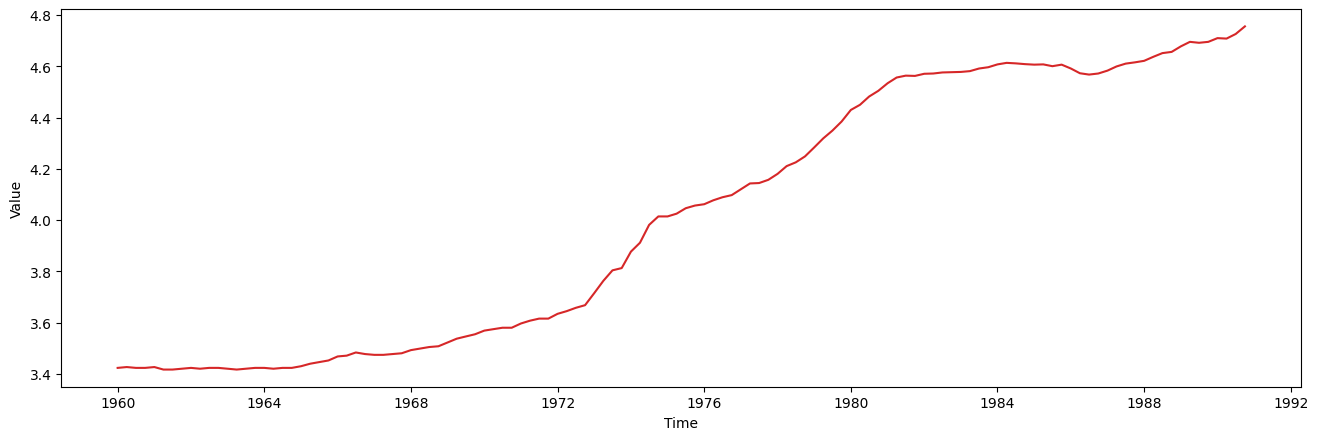

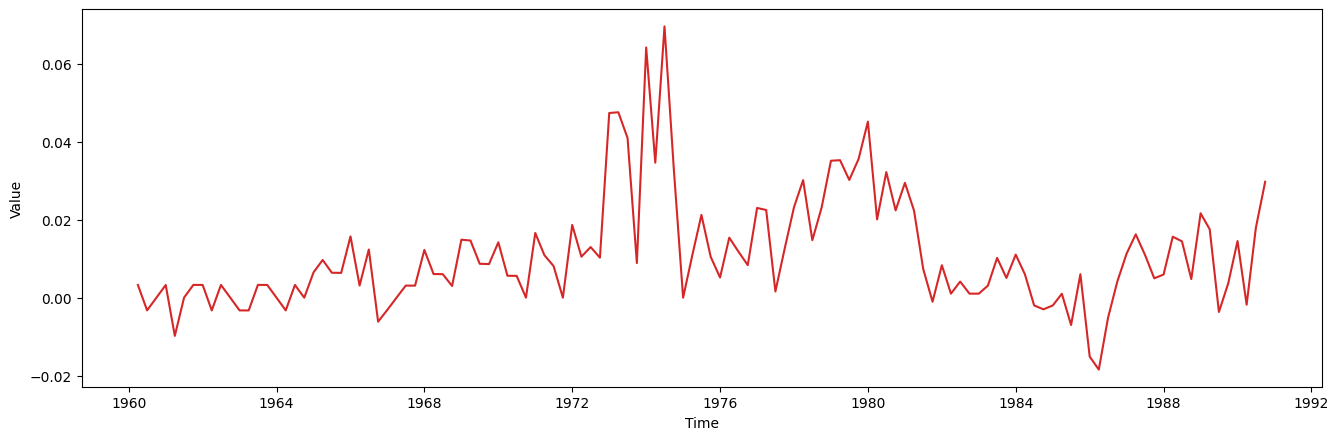

<bound method Figure.show of <Figure size 432x288 with 1 Axes>>

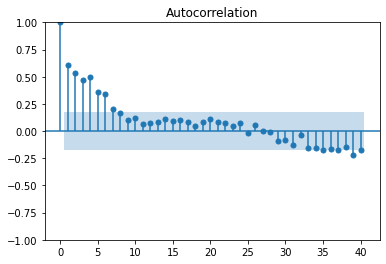

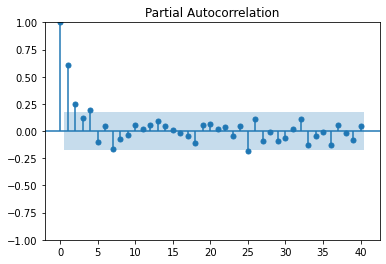

In [32]:
# 直接使用数据集中提供的对数处理后的数据，实际中我们可能要比较两种数据的出来的效果，这里我们跳过
plot_ts_df(wpi1,x=wpi1.index,y=wpi1.ln_wpi)

# 趋势差分
wpi1['ln_wpi_1']=wpi1['ln_wpi'].diff(periods=1)

# 观察时序图、acf、pacf
plot_ts_df(wpi1,x=wpi1.index,y=wpi1.ln_wpi_1)
plot_acf(wpi1.ln_wpi_1.dropna(),lags=40,bartlett_confint=False).show
plot_pacf(wpi1.ln_wpi_1.dropna(),lags=40,method='ywm').show


该序列的acf与pacf都呈现出一定的拖尾，我们可以考虑使用ARMA模型，并向大家介绍“稀系数”。

In [33]:
# 在这里我们使用ARMA(1,4)模型
arma14=sm.tsa.SARIMAX(wpi1.ln_wpi,order=(1,1,4),trend='c').fit(disp=False)
print(arma14.summary())

                               SARIMAX Results                                
Dep. Variable:                 ln_wpi   No. Observations:                  124
Model:               SARIMAX(1, 1, 4)   Log Likelihood                 386.176
Date:                Sat, 21 May 2022   AIC                           -758.352
Time:                        20:41:45   BIC                           -738.666
Sample:                    01-01-1960   HQIC                          -750.355
                         - 10-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0029      0.002      1.597      0.110      -0.001       0.006
ar.L1          0.7397      0.114      6.509      0.000       0.517       0.962
ma.L1         -0.3723      0.135     -2.756      0.0

我们观察一下这个模型各系数的显著性，即p值。ar1、ma1、ma4的显著性都小于或接近于0.01，是非常显著的；而ma2、ma3的p值却远大于0.05，这说明这两个系数不显著，我们可以考虑将它们忽略掉。那么我们为什么要将不显著的系数忽略掉呢？因为这样可以减少模型的无用参数以降低模型的复杂度。注意：尽管从表中得知截距项似乎也不太显著，但是我们从原始序列中可以看出序列是带有趋势性的，若进行了差分消除趋势后，中心化（去掉截距项）会导致预测出现严重错误，因此我不太建议去掉截距项。

去掉模型中不显著系数的模型被称为稀系数模型。在指定order=(p,d,q)时，如果直接将p、q赋值为一个整数，那么模型会输出对应数值个的参数；如果想要创建稀系数，则将整数替换成数组。在这一例中我们将q=4替换成(1,0,0,1).

In [34]:
arma14=sm.tsa.SARIMAX(wpi1.ln_wpi,order=(1,1,(1,0,0,1)),trend='c').fit(disp=False)
print(arma14.summary())

                                 SARIMAX Results                                 
Dep. Variable:                    ln_wpi   No. Observations:                  124
Model:             SARIMAX(1, 1, [1, 4])   Log Likelihood                 386.034
Date:                   Sat, 21 May 2022   AIC                           -762.067
Time:                           20:41:45   BIC                           -748.006
Sample:                       01-01-1960   HQIC                          -756.356
                            - 10-01-1990                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0024      0.002      1.484      0.138      -0.001       0.006
ar.L1          0.7811      0.095      8.264      0.000       0.596       0.966
ma.L1         -0.3999      0

最后进行白噪声检验。

In [35]:
arma14_resid=arma14.resid
arma14_resid.drop('1960-01-01',inplace=True)
acorr_ljungbox(arma14_resid,lags=10,model_df=3)

,lb_stat,lb_pvalue
1,0.022721,NaN
2,0.022991,NaN
3,0.192116,NaN
4,0.210640,0.646266
5,0.890533,0.640653
6,2.586321,0.459893
7,2.933399,0.569032
8,2.955528,0.706842
9,4.117752,0.660745
10,4.146865,0.762715


模型非常充分，说明这个建模是成功的。

## 2.6 ARIMA过程

我们已经对ARMA类模型有了较为全面地介绍，最后简单介绍一下ARIMA模型。

如果序列$X_t$满足$\nabla^{d} X_{t} \sim A R M A(p, q)$，则称$X_t$为一个求和自回归移动平均过程，记为：
$$
X_{t} \sim A R I M A(p, d, q)
$$
算子表示为：
$$
\phi(B)(1-B)^{d} X_{t}=\theta(B) Z_{t}
$$
ARIMA模型在ARMA模型的基础上多了一个对序列差分运算，这就意味着ARMA模型是平稳模型而ARIMA模型是非平稳模型，它应用于非平稳序列当中。如果序列是带有趋势性的非平稳序列，那么带有差分项的ARIMA一定不能轻易的去掉截距项。一般而言，差分阶数$d$通常不会很大，设置为1或2就足够了。

实际上，我们前面构建的所有模型，都算是ARIMA建模，因为我们都对原始序列进行了差分运算。大家只要掌握了前面的知识，就已经对ARIMA建模有了初步的了解了！

# 3. SARIMA——ARIMA模型的季节性拓展

介绍完ARIMA类模型，我们最后来学习它的最终形态——SARIMA类模型。它是包含了季节性的ARIMA模型，在这一部分，我们会介绍一些经典的季节性模型。

## 3.1 简单季节模型

**· 定义**

如果序列中同时存在趋势性和季节性，通过趋势差分与季节差分消除趋势性和季节性后，序列可以化为平稳序列并建立ARMA模型，这类模型被称为简单季节模型：
$$
\Phi(B) \nabla_{S}^{D} \nabla^{d} X_{t}=\Theta(B) Z_{t}
$$
简单季节模型没有太多值得说明的地方，我们在前面进行AR建模实操时构建的AR(4)模型其实就是一个简单季节模型（因为进行了季节性差分）。

## 3.2 乘积季节模型

在前面，序列经过趋势差分与季节差分后，其ACF结构呈现出了较为简单的形式，如快速截尾、自相关只存在短期效应等等。然而，有一些时间序列在进行了差分后的ACF结构依旧复杂，其短期相关与季节性相关交互影响，其后果是ACF呈现出季节维度上的变化。如果我们直接用ARMA类模型建模，会导致参数过多，模型复杂度过高。为解决这一问题，我们引入乘积季节模型。

### 3.2.1 乘积季节模型的定义

乘积季节模型模型$A R I M A(p, d, q) \times(P, D, Q)_{S}$具有以下算子形式：
$$
\tilde{\Phi}_S(B)\Phi (B)\nabla _{S}^{D}\nabla ^dX_t=\tilde{\Theta}_S(B)\Theta (B)Z_t
$$
其中：
$$
\begin{aligned}
\Phi(B) &=1-\phi_{1} B-\phi_{2} B^{2}-\cdots-\phi_{p} B^{p} \\
\tilde{\Phi}_{S}(B) &=1-\tilde{\phi}_{1} B^{S}-\tilde{\phi}_{2} B^{2 S}-\cdots-\tilde{\phi}_{P} B^{P S} \\
\theta(B) &=1-\theta_{1} B-\theta_{2} B^{2}-\cdots-\theta_{q} B^{q} \\
\tilde{\Theta}_{S}(B) &=1-\tilde{\theta}_{1} B^{S}-\tilde{\theta}_{2} B^{2 S}-\cdots-\tilde{\theta}_{Q} B^{Q S}
\end{aligned}
$$
可以看到，相比于ARIMA模型$\phi(B)(1-B)^{d} X_{t}=\theta(B) Z_{t}$，SARIMA模型多了一个季节差分项，以及等式两边**乘上了两个形式上与MA/AR算子相似，但延迟项算子B维度从1延长至季节长度s的季节MA/AR算子。**之所以将该模型称为乘积季节模型，是因为季节公式的算子与非季节公式的算子是相乘的，这也意味着模型中短期自相关与季节自相关的影响是交互的。

### 3.2.2 ACF计算

**纯季节模型**

我们先来简单看看只有季节项参数，没有非季节项参数的SARIMA模型，以几个简单的模型为例。

考虑一阶季节移动平均模型$MA(1)_{12}$：
$$
X_t=\left( 1-\tilde{\theta}_1B^{12} \right) Z_t=Z_t-\tilde{\theta}_1Z_{t-12}
$$
根据ACF计算中“时刻重合的$Z_t$自协方差不为0”的特点，可以容易计算出ACF为：
$$
\rho (12)=-\frac{\tilde{\theta}_1}{1+\tilde{\theta}_{1}^{2}}\text{；}\rho (k)=0\text{，}k\ne 12
$$
再考虑一阶季节自回归模型$A R(1)_{12}$：
$$
X_t=\tilde{\phi}_1X_{t-12}+Z_t
$$
其ACF为：
$$\rho(12 k)=\tilde{\phi}_{1}^{k}, k=0,1,2, \cdots$$
我们比较一下季节AR(1)与AR(1)的ACF的区别：

In [36]:
%%html
<img src='SAR1.png'>

我们发现，对于纯季节模型，它们的ACF（PACF也同理）呈现出来的特征极其相似，只不过季节模型ACF(PACF)显著的延迟阶数是以季节周期为维度的，这将帮助我们对纯季节模型进行定阶。

**短期自相关/季节乘积模型**

在实际的时间序列分析当中，序列中很少出现不存在短期自相关的情况。带有季节性自相关的平稳时间序列一般也会存在短期自相关效应，因此我们使用的更多的是两种效应都存在的乘积模型。

当模型同时存在非季节性模型参数与季节性模型参数时，模型的ACF、PACF的表现就比较复杂了。在这里我们简单介绍一下ARMA(0,1)(1,0)、ARMA(1,0)(0,1)以及重点介绍航空模型ARMA(0,1)(0,1)，并以它们为例教会大家如何粗略地为乘积模型定阶。

首先看$ARMA(0,1) \times(1,0)_{12}$：
$$
\left( 1-\tilde{\phi}_1B^{12} \right) X_t=\left( 1-\theta _1 \right) Z_t
$$
直接给出它们的ACF表达式以及ACF/PACF图
$$
\begin{gathered}
\rho(12 k)=\tilde{\phi}_{1}^{k}, k=1,2 \cdots \\
\rho(12 k \pm 1)=-\frac{\theta_{1}}{1+\theta_{1}^{2}} \tilde{\phi}_{1}^{k}, k=1,2 \cdots
\end{gathered}
$$




In [37]:
%%html
<img src='arma0110.png'>

ARMA(0,1)(1,0)可以解读为一个MA(1)与一个季节AR(1)的乘积，它同时包含这两个模型的自相关与偏自相关信息，**它们的乘积效应体现在短期自相关信息“附着在”季节自相关信息上**。如何理解这句话？我们观察上面两图：模型含有季节AR(1)项，则它的PACF会在一个季节长度s后截尾，而ACF则会呈现出以季节周期s为维度的拖尾性；同时，模型含有非季节MA(1)项，可以看到模型在每个显著的季节ACF周围，都会短暂的出现不为0的ACF并迅速衰减至0（ACF截尾），同时在每个显著的季节PACF的后续时间段内呈现出明显的PACF拖尾。这启发了我们，短期自相关效应可能在ACF/PACF图中表现为依傍于季节自相关相应，因此我们可以尝试先查看季节维度的自相关表现并进行季节模型定阶，再查看非季节维度并进行非季节模型的定阶。

我们再看一个例子ARMA(1,0)(0,1):

In [38]:
%%html
<img src='arma1001.png'>

它可以解读为一个AR(1)与一个季节MA(1)的乘积，在季节维度上，该模型在$S=1$时ACF就截尾了，且PACF呈现出季节上的拖尾；同时，由于AR(1)的存在，在季节ACF(1)截尾后，它后续呈现出了明显的非季节ACF拖尾性，且非季节PACF值都非常低（PACF截尾）。

**航空模型**

航空模型$\operatorname{ARIMA}(0,1,1) \times(0,1,1)_{S}$是最经典的季节成绩模型，被广泛地应用至季节时间序列的建模当中，其算子表达式如下所示：
$$
\nabla _S\nabla X_t=\left( 1-\theta _1B \right) \left( 1-\tilde{\theta}_1B^S \right) Z_t
$$
它同时包含了趋势、季节差分与季节、非季节MA(1)模型。由于只包含MA模型的参数，意味着$X_t$可以展开成有限个随机扰动项$Z_{t-p}$（这个模型可以展开成4个），我们可以轻松算出它的各阶ACF：
$$
\begin{gathered}
\rho(1)=-\frac{\theta_{1}}{1+\theta_{1}^{2}}, \rho(S)=-\frac{\tilde{\theta}_{1}}{1+\tilde{\theta}_{1}^{2}} \\
\rho(S \pm 1)=\rho_{1} \rho_{s}=\frac{\theta_{1} \tilde{\theta}_{1}}{\left(1+\theta_{1}^{2}\right)\left(1+\tilde{\theta}_{1}^{2}\right)}
\end{gathered}
$$
航空模型的ACF只有在k=1、S-1、S、S+1除不等于0。此外，我们也可以根据公式知道，ACF在k=1、S时较大，在k=S-1、S+1时较小。

### 在Python中进行SARIMA建模

在这里我们用经典的美国航空乘客人数数据集进行季节建模，在这个建模实例当中，大家能可以看到：一个时间序列适合的模型是不唯一的，我们只能选择出相对较优的模型。模型对比的具体细节，我们将在下一大章节展示，在这里我们只做简单介绍。

In [39]:
# 回顾AirPassenger数据集
air.head()

,year,month,Number,Time,Number_log,Number_log_diff1,Number_log_diff1_diff12
1949-01-01,1949,1,112,1949-1,4.727388,NaN,NaN
1949-02-01,1949,2,118,1949-2,4.779123,0.051736,NaN
1949-03-01,1949,3,132,1949-3,4.890349,0.111226,NaN
1949-04-01,1949,4,129,1949-4,4.867534,-0.022815,NaN
1949-05-01,1949,5,121,1949-5,4.804021,-0.063513,NaN


<bound method Figure.show of <Figure size 432x288 with 1 Axes>>

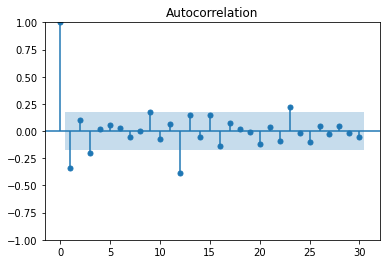

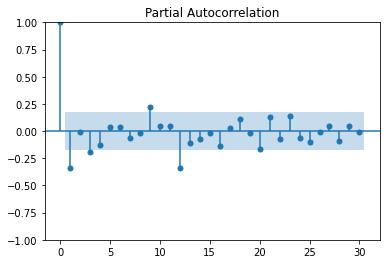

In [41]:
# 我们对初始数据进行了对数化、趋势差分、季节差分，现在来看看处理过后的acf与pacf
plot_acf(air.Number_log_diff1_diff12.dropna(),lags=30,bartlett_confint=False).show
plot_pacf(air.Number_log_diff1_diff12.dropna(),lags=30,method='ywm').show

我们看到，该序列ACF与PACF的特征非常相似，都在1与12阶处非常显著，除此以外其他阶数显著程度较低。我们可以考虑纯季节模型，但是我更建议大家使用乘积模型。我们考虑ARMA(1,0)(1,0)航空模型与ARMA(0,1)(0,1)。

In [57]:
arma0101=sm.tsa.SARIMAX(air.Number_log,order=(0,1,1),seasonal_order=(0,1,1,12),trend='c').fit()
arma0101_resid=arma0101.resid
arma0101_resid.drop('1949-01-01',inplace=True)

arma1010=sm.tsa.SARIMAX(air.Number_log,order=(1,1,0),seasonal_order=(1,1,0,12),trend='c').fit()
arma1010_resid=arma1010.resid
arma1010_resid.drop('1949-01-01',inplace=True)


In [58]:
# 白噪声检验
display(acorr_ljungbox(arma0101_resid,lags=10))
display(acorr_ljungbox(arma1010_resid,lags=10))

,lb_stat,lb_pvalue
1,0.662958,0.415517
2,0.882600,0.643200
3,1.175745,0.758827
4,1.308811,0.859879
5,1.410406,0.923172
6,1.984913,0.921081
7,2.619667,0.917820
8,2.623232,0.955737
9,2.667877,0.976023
10,2.936008,0.982890


,lb_stat,lb_pvalue
1,0.692059,0.405465
2,0.858079,0.651134
3,1.168857,0.760483
4,1.311171,0.859477
5,1.404945,0.923772
6,1.971843,0.922270
7,2.545880,0.923603
8,2.557324,0.959004
9,2.616057,0.977598
10,2.864954,0.984426


两个模型都有效，我们使用AIC/BIC比较两个模型的复杂度，复杂度低的模型较优。

In [59]:
print(arma0101.summary())
print(arma1010.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Number_log   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 245.302
Date:                            Sat, 21 May 2022   AIC                           -482.605
Time:                                    22:09:06   BIC                           -471.104
Sample:                                01-01-1949   HQIC                          -477.931
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.001     -0.155      0.877      -0.002       0.002
ma.L1         -0.4011      0.073   

模型的AIC与BIC越低越好，因此航空模型ARMA(0,1)(0,1)效果更好，我们应当选取航空模型。

# 3. ARIMA类模型建模流程全解

我们先简单回顾一下前面所学的东西。

我们首先进行了对平稳过程的学习，知晓了平稳过程在时间序列建模中的重要性、如何粗略地判断序列的平稳性以及如何进行序列的平稳化；基于平稳序列，我们详细地介绍了各种ARIMA类的模型，包括它们的各种性质、模型的识别、建模中的细节以及模型有效性的检验等。我们将ARIMA建模比作一栋房子，如果各位同学已经熟练地掌握了上述知识，大家建房子所需的材料基本上到位了，接下来我们将学习如何通过一套程式化的流程进行完整的ARIMA建模。

在对ARIMA建模程式化流程的学习中，我们额外补充了下述知识点，它们都非常重要，希望同学们可以细心钻研：
<br>
· 严格的平稳性检验——单位根检验
<br>
· 模型比较的两种方法——样本内/样本外比较法
<br>
· 模型预测的原理

# 3.1 时间序列建模流程

### 3.1.1 流程介绍

时间序列建模的一般流程可以用下图概括：

In [1]:
%%html
<img src='建模流程.png'>

### 3.1.2 流程解析

我们一一解析时序程式化分析的每一步骤：

**· 可视化分析**

时序分析的第一步永远是先绘制时序图与ACF图，时序图可以直观地看出序列是否含有趋势、是否含有季节性、方差是否稳定等信息；而通过对ACF图各延迟阶数ACF显著性的观察，我们也能对序列的平稳性进行判断。可以认为，这一步骤可以帮我们粗略地判断初始序列的平稳性。

**· 严格平稳性判断**

在前面我们只通过时序图与ACF图对序列的平稳性进行粗略判断，这是一种相对主观的方法，并不严格；此外，不平稳序列的类型也有很多，不同类型的不平稳序列的平稳化处理方式也不同。因此我们需要一种确切的方法告诉我们：序列是否严格的平稳？序列不平稳的类型是什么？它是否趋势平稳还是差分平稳？它是否带有截距？等等，这种确切方法就是Dickey-Fuller检验与Augmented Dickey-Fuller检验。

**· 序列平稳化**

结合前面两步的判断，对序列进行针对性的平稳化措施。若方差不稳定，可使用Box-Cox变换；若序列是趋势平稳，则减去序列的确定性趋势；若序列是差分平稳，则通过趋势差分消除趋势；若序列含有季节性，则采用季节差分消除季节性。

**· 模型识别与参数估计**

序列平稳化后，通过ACF图与PACF图进行模型定阶，并选择参数估计的方式（条件最小二乘估计、极大似然估计等等），参数估计方式的选择不要求掌握。

**· 模型充分性检验与多模型比较**

使用白噪声检验进行模型充分性检验；由于对于同一数据往往可以建立多个充分的模型，因此需要比较不同模型的优劣，选取最优的模型。

**· 模型预测**

模型预测的原理是什么？

## 3.2 严格的平稳性判断——单位根检验